In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pylab import zeros
plt.rcParams['figure.dpi']= 150
import struct
import random
import time

from decimal import Decimal

import gzip

def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
    
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10))
    e[j] = 1.0
    return e

def get_images(training_set):
    """ Return a list containing the images from the MNIST data
    set. Each image is represented as a 2-d numpy array."""
    flattened_images = training_set
    return [np.reshape(f, (-1, 28)) for f in flattened_images]

In [2]:
tr_d_inputs=read_idx("data/train-images-idx3-ubyte.gz")

In [3]:
tr_d_results=read_idx("data/train-labels-idx1-ubyte.gz")

In [4]:
training_inputs = [np.reshape(x/255, (784)) for x in tr_d_inputs]

In [5]:
training_results = [vectorized_result(y) for y in tr_d_results]

In [6]:
temp_train_data=training_inputs, training_results
training_data=np.transpose(temp_train_data)

In [7]:
te_d_inputs=read_idx("data/t10k-images-idx3-ubyte.gz")

In [8]:
te_d_results=read_idx("data/t10k-labels-idx1-ubyte.gz")

In [9]:
test_inputs = [np.reshape(x/255, (784)) for x in te_d_inputs]

In [10]:
test_results = [vectorized_result(y) for y in te_d_results]

In [11]:
temp_test_data=test_inputs, test_results
test_data=np.transpose(temp_test_data)

In [12]:
len(training_data),len(test_data)

(60000, 10000)

In [13]:
images = get_images(tr_d_inputs)

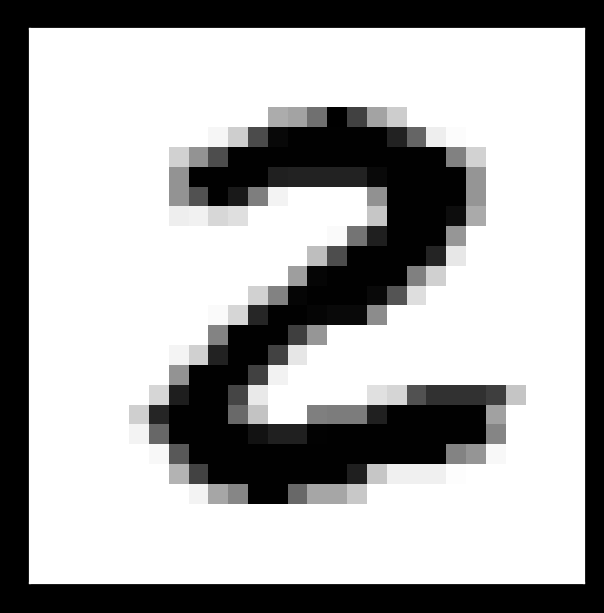

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.matshow(images[25], cmap = matplotlib.cm.binary)
plt.xticks(np.array([]))
plt.yticks(np.array([]))
plt.show()

In [15]:
def sigmoid(x):
    return 1.0/(1+ np.exp(-x))

In [16]:
def sigmoid_derivative(x):
    return x * (1.0 - x)

In [17]:
class NeuralNetwork:
    def __init__(self, x, y, HiddenLayerSize, etaVar):
        self.hls        = HiddenLayerSize
        self.eta        = etaVar
        self.input      = x
        self.y          = y
        self.biases1    = np.random.randn(self.input.shape[0],self.hls)
        self.biases2    = np.random.randn(self.y.shape[0],self.y.shape[1])
        self.weights1   = np.random.randn(self.input.shape[1],self.hls) 
        self.weights2   = np.random.randn(self.hls,self.y.shape[1])                 
        self.output     = np.zeros(self.y.shape)

    def feedforward(self, x):
        self.input      = x
        self.layer1 = sigmoid(np.dot(self.input, self.weights1)+self.biases1)
        self.output = sigmoid(np.dot(self.layer1, self.weights2)+self.biases2)
        
    def evaluate(self, x, y):
        self.input      = x
        self.y          = y
        self.output     = np.zeros(self.y.shape)
        self.layer1 = sigmoid(np.dot(self.input, self.weights1)+self.biases1)
        self.output = sigmoid(np.dot(self.layer1, self.weights2)+self.biases2)
        return self.output

    def backprop(self, x, y):
        self.input      = x
        self.y          = y
        # use chain rule to get derivative of loss function w.r.t. weights2 and weights1
        d_weights2 = np.dot(self.layer1.T, (2*(self.y - self.output) * sigmoid_derivative(self.output)))
        d_weights1 = np.dot(self.input.T,  (np.dot(2*(self.y - self.output) * sigmoid_derivative(self.output), self.weights2.T) * sigmoid_derivative(self.layer1)))
        d_biases2 = (2*(self.y - self.output) * sigmoid_derivative(self.output))
        d_biases1 = (np.dot(2*(self.y - self.output) * sigmoid_derivative(self.output), self.weights2.T) * sigmoid_derivative(self.layer1))

        # d(loss)/d(weights) = delta(weights)
        self.weights1 += (self.eta/len(mini_batch))*d_weights1
        self.weights2 += (self.eta/len(mini_batch))*d_weights2
        self.biases1 += (self.eta/len(mini_batch))*d_biases1
        self.biases2 += (self.eta/len(mini_batch))*d_biases2

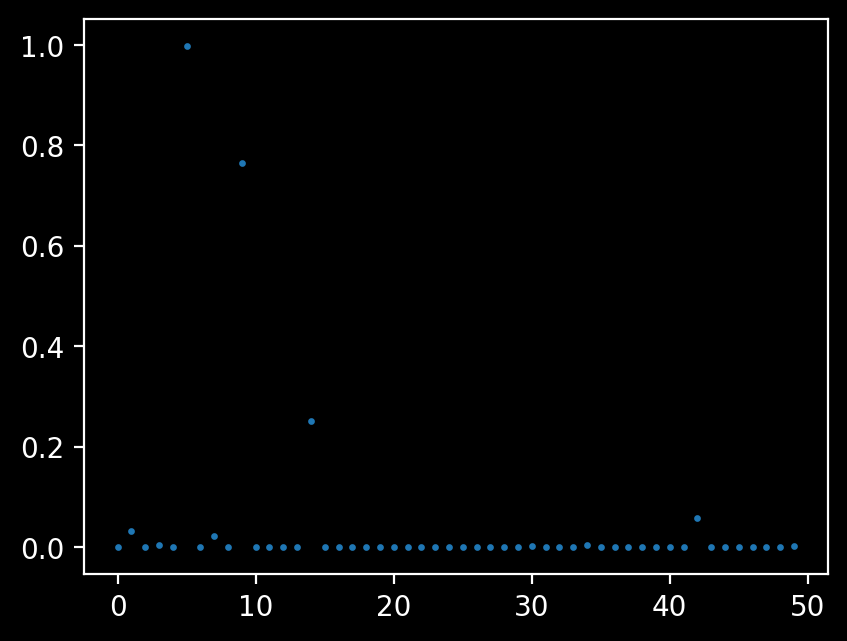

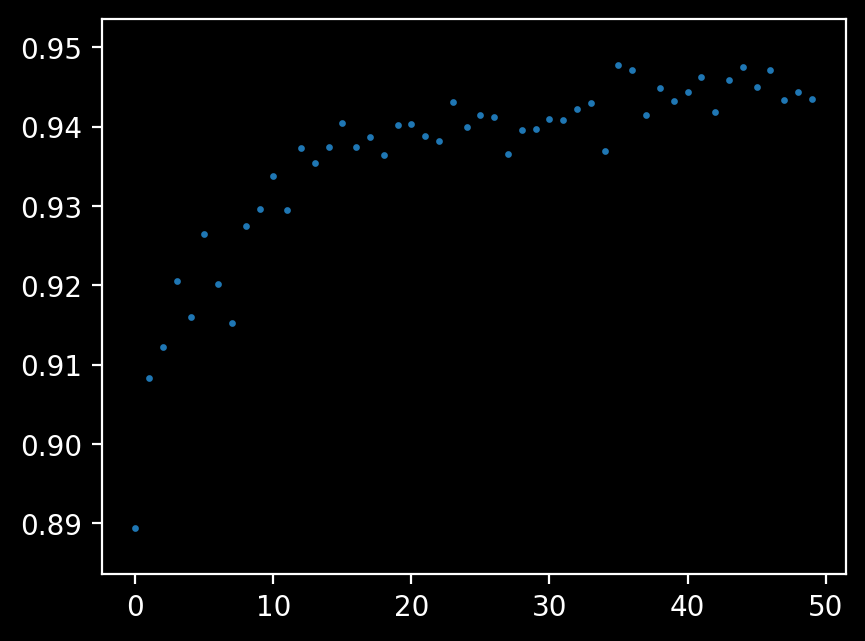

training took: 368.0 seconds
for: 50 epochs
and: 2000 mini-batches with mini-batch size: 10
final accuracy on test set: 94.3 %


In [18]:
start = time.time()
if __name__ == "__main__":
    epochs = 50
    mini_batch_size=10
    n = 20000
    """for full data set, use: n = len(training_data)"""
    X = np.array(training_inputs[0:1])
    y = np.array(training_results[0:1])
    nn = NeuralNetwork(X,y,30,5)

    iterationCounter=zeros(epochs)
    lossData=zeros(epochs)
    trainAccuracy=zeros(epochs)
    
    for i in range(epochs):
        np.random.shuffle(training_data)
        mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
        for mini_batch in mini_batches:
            for xx, yy in mini_batch:
                nn.feedforward(np.reshape(np.array(xx),(1,784)))
                nn.backprop(np.reshape(np.array(xx),(1,784)),yy)
        iterationCounter[i]=i
        # if i%10 == 0:
        #         print(nn.output)
        lossData[i]=np.dot(np.matrix.flatten(nn.y)-np.matrix.flatten(nn.output),np.matrix.flatten(nn.y)-np.matrix.flatten(nn.output))
        testset_evaluation = [(np.argmax(nn.evaluate(x,y)), np.argmax(y)) for (x, y) in test_data]
        trainAccuracy[i]=sum(int(x == y) for (x, y) in testset_evaluation)/len(testset_evaluation)

    # print(nn.output)
    # print(nn.feedforward())
    # print(X.shape[1])
    # print(np.matrix.flatten(nn.y))
    # print(np.dot(np.matrix.flatten(nn.y)-np.matrix.flatten(nn.output),np.matrix.flatten(nn.y)-np.matrix.flatten(nn.output)))
    # print(iterationCounter[1499]+1)
    # print(lossData[0])
    
    plt.scatter(iterationCounter, lossData, s=2)
    plt.savefig("loss_function_evolution.png", dpi=300)
    plt.show()
    plt.scatter(iterationCounter, trainAccuracy, s=2)
    plt.savefig("training_accuracy_evolution.png", dpi=300)
    plt.show()
end = time.time()
testset_evaluation = [(np.argmax(nn.evaluate(x,y)), np.argmax(y)) for (x, y) in test_data]
finalAcc = sum(int(x == y) for (x, y) in testset_evaluation)/len(testset_evaluation)
print("training took: {} seconds".format(np.round(end-start)))
print("for: {} epochs".format(epochs))
print("and: {} mini-batches".format(np.int(n/mini_batch_size)),"with mini-batch size: {}".format(mini_batch_size))
print("final accuracy on test set: {} %".format(float(round(Decimal(100*finalAcc),1))))

In [20]:
testimages = get_images(te_d_inputs)

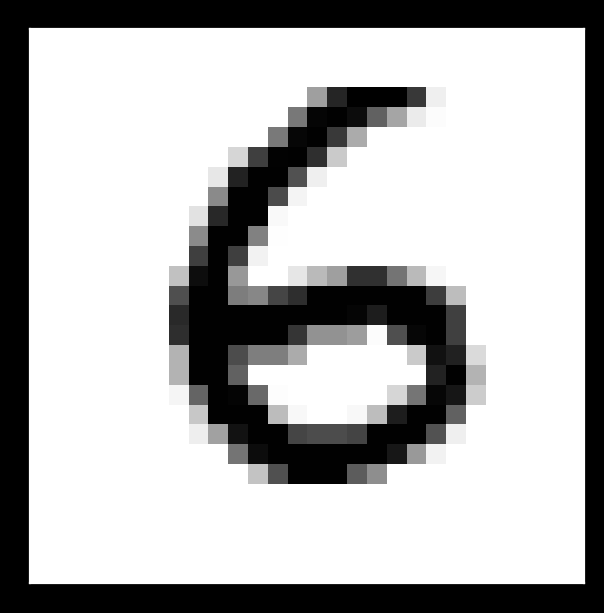

In [21]:
testdatapoint=2876
fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 1, 1)
ax2.matshow(testimages[testdatapoint], cmap = matplotlib.cm.binary)
plt.xticks(np.array([]))
plt.yticks(np.array([]))
plt.show()

In [22]:
print(np.argmax(test_data[testdatapoint][1]))
print(np.argmax(nn.evaluate(test_data[testdatapoint][0],test_data[testdatapoint][1])))

6
6
